# Team 2121741 Problem D Code (The Influence of Music)

Solution for 2021 ICM (Interdisciplinary Contest in Modeling).

<h2> Introduction </h2>

This notebook focuses on analyzing the influence of music through networks using illustrative visualizations, statistical analyses, and predictive modeling. In the first section, we analyze the inherent similarities of music within and between genres using a K-Means clustering algorithm and visualize the data using T-distributed Stochastic Neighbor Embedding dimensionality reduction. We continue by analyzing which genres have music most similar to each other (aside from themselves). To do so, we utilize a Pearson correlation matrix and plot the genres with significant correlation on a bar chart.

In the second section, we devise a novel method of calculating influence scores by combining a breadth-first search algorithm with an exponential decay function, and then plot the top influence scores on a bar chart. We also extract the timeframe of an influencer influencing a follower and create meaningful subnetwork visualizations using NetworkX.

In the third section, we analyze whether influencers have a significant impact on their followers by deploying a K-Nearest Neighbors algorithm. We observe that influencers should have similar music to their followers if there is true influence, and therefore they should be neighbors with one another when plotted in multi-dimensional space. 

In the fourth section, we built a predictive model using XGBoost and extracted the most important & distinguishing features for genre prediction. We supplemented our feature importance analysis with alternative statistical testing.

In the fifth and final section, we explored trends in how songs characteristics have changed over time and connected them to real world events and explanations. We made observations about trends for all songs, and also specifically analyzed Rhythm and Blues (R&B) and its most influential artists.

Through these analyses, we hope to enlighten the reader on the influence of music through networks and how music has changed over time using a combination of math, computer science, and of course, music.

<h2> Problem Statement </h2>

Problem Statement: https://www.comap-math.com/mcm/2021_ICM_Problem_D.pdf

Music has the power to culturally, morally, and emotionally influence our society. The sound and messages artists release through their art form directly impact their followers and listeners in powerful ways (Huang, 2014). In an effort to better understand the impact of music on musical artists and society, we have been asked by the Integrative Collective Music (ICM) Society to analyze musical influence across time, genres, and artists. The primary focus of this paper is to capture revolutionary changes, extraneous circumstances, and influential artists using illustrative visualizations and analyses.

<h2> Important Definitions </h2>

* **Cluster:** A group of data tightly packed together in some dimension.
* **Feature:** Analogous to “characteristic”. This notation is used interchangeably throughout the paper.
* **Primary artist features:** ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'mode', 'key', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'duration_ms', 'popularity', 'count']
* **Z-score:** A standard unit of measurement. Each sample x in our dataset is scaled down to z-scores using the formula z = x-μ/𝜎, where μ is the mean and 𝜎 is the standard deviation.

<h2> Problem Assumptions </h2>

* **Assumption 1:** The data given in the datasets “influence_data”, “full_musics_data”, “data_by_artist”, and “data_by_year” is accurate.
    * **Reasoning:** The efficacy of our analysis is largely dependent on the accuracy of the data. Because we cannot use any other data in this paper, we must assume that the data provided to us is correct.
* **Assumption 2:** Each feature in the dataset has equal weighting; normalizing the data using z-scores is sufficient for analysis.
    * **Reasoning:** There’s no reasonable way to weigh certain features heavier than others.
* **Assumption 3:** Two genres or artists being similar is defined by and only by the inherent characteristics in their music, and not by extraneous factors such as genre and song title.
    * **Reasoning:** The whole purpose of using these numerical features is to analyze whether there are inherent similarities between genres/artists.
* **Assumption 4:** Drop song and artists in the genre “Unknown” and “Children’s”.
    * **Reasoning:** There are only 3 artists labeled under “Unknown” and 4 artists labeled under “Children’s”, compared to the 5653 total artists in the data.

<h2> Appendices/Other Resources </h2>

* Prediction models notebook (to separate GPU usage): https://www.kaggle.com/ironicninja/the-influence-of-music-prediction-models
* Officially submitted paper: https://docs.google.com/document/d/1GxArjRCE95swOcifBco8uLnS9-ABKzQetMoKBTBmtWA/

In [ ]:
"""General Data Science Packages"""
import numpy as np
import pandas as pd
import os
import sys

"""Graphing Packages"""
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import networkx as nx
import seaborn as sns

"""Other Useful Libraries"""
import random
import math
import itertools
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from collections import Counter
from sklearn.model_selection import GroupKFold, StratifiedKFold, RepeatedStratifiedKFold
import multiprocessing
import scipy

LOOK_AT = 10
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
data_by_artist = pd.read_csv("../input/icm-problem-d/2021_ICM_Problem_D_Data/data_by_artist.csv")
data_by_year = pd.read_csv("../input/icm-problem-d/2021_ICM_Problem_D_Data/data_by_year.csv")
full_music_data = pd.read_csv("../input/icm-problem-d/2021_ICM_Problem_D_Data/full_music_data.csv")
influence_data = pd.read_csv("../input/icm-problem-d/2021_ICM_Problem_D_Data/influence_data.csv")

# Task #1: Similarities Within and Between Genres

Notes: We use artist names instead of ID; when exploring the data, we noticed that some artists (grouped by names) were counted in more than 1 genre, but when using artists (grouped by ID), artists were surjective. Our team was unsure as to whether different IDs implied different artists or if it implied a change in genre of artists. The difference should be negligible for these visualizations, but should be considered for future work.

<h3> Questions of Focus </h3>

* Are artists within genre more similar than artists between genres? 
* Are some genres related to others?

<h2> Are artists within genres more similar than artists between genres? </h2>

**Observation:** Per Assumption 3, if artists within a genre are more similar to each other than to artists outside of their genre, the characteristics of their music should be similar enough such that we can accurately cluster and distinguish music from one genre to another.

In [ ]:
features_list = data_by_artist.columns[2:]
features_list

<h3> Generate Dictionary </h3>

In [ ]:
id_genre_dict = {}

for i in range(len(influence_data)):
    row = influence_data.loc[i]
    in_id = row['influencer_name']
    fol_id = row['follower_name']
    in_genre = row['influencer_main_genre']
    fol_genre = row['follower_main_genre']
    if in_id not in id_genre_dict:
        id_genre_dict[in_id] = set()
    id_genre_dict[in_id].add(in_genre)
    
    if fol_id not in id_genre_dict:
        id_genre_dict[fol_id] = set()
    id_genre_dict[fol_id].add(fol_genre)

Print out which artists domain over more than one genre. (Are there multiple people named the same thing as the people below?)

In [ ]:
c = 0
for k, v in id_genre_dict.items():
    c += 1
    if len(v) != 1:
        print(k, v)

<h3> Generate New DataFrame </h3>

DataFrame is generated from original ```data_by_artist``` file, but now incorporates ```id_genre_dict``` and shows the genre for each artist. Artists with multiple genres were duplicated, and we believe this is a fine practice, since there are ```< 20``` duplicate artists anyways (and there was no simple way to distinguish an artist being in one of the genres compared to the other). We also drop the genre ```Unknown``` (3) and ```Children's``` (4) in our analysis.

In [ ]:
%%time

artist_df = pd.DataFrame()
artists_not_included = []
for i in range(len(data_by_artist)):
    try:
        for genre in id_genre_dict[data_by_artist.loc[i]['artist_name']]:
            if genre == "Unknown" or genre == "Children's":
                continue
            tmp_df = pd.DataFrame(data_by_artist.loc[i]).T
            tmp_df['genre'] = genre
            artist_df = pd.concat((artist_df, tmp_df))
    except:
        artists_not_included.append(data_by_artist.loc[i]['artist_name'])
        
#print(artists_not_included)
artist_df = artist_df.reset_index().drop("index", axis=1)
artist_df

<h3> K-Means Clustering </h3>

Parameters: https://realpython.com/k-means-clustering-python/.

We utilize a K-Means Clustering Algorithm to group our data. This algorithm uses Expectation-Maximization to mathematically assign groupings and find the centroid of each cluster (Dabbura, 2018). We initialize the number of clusters equal to the number of genres in our dataset (18). Remember, data is ALREADY normalized with the StandardScaler function here! We set the parameters of n_init and max_iter high to generate the most accurate clustering possible. 

In [ ]:
genre_list = artist_df['genre'].unique()
genre_list.sort()
N_CLUSTERS = len(genre_list)

cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=N_CLUSTERS, n_init=50, max_iter=1000, random_state=SEED))])
X = artist_df.loc[:, features_list]
cluster_pipeline.fit(X)
artist_df['cluster'] = cluster_pipeline.predict(X)
artist_df

<h3> TSNE Dimensionality Reduction </h3>

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

We also utilize T-distributed Stochastic Neighbor Embedding (t-SNE) to reduce the dimensionality of our data from 14 (length of primary artist features) to 2. Since our primary objective with dimensionality reduction is visualization (so not for predictive models), we choose t-SNE instead of the popular alternative Principal Components Analysis (Kapri, 2020).

In [ ]:
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, random_state=SEED))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genre'] = artist_df['genre']
projection['cluster'] = artist_df['cluster']
projection

In [ ]:
fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genre'])
fig.update_layout(title={'text': "K-Means Generated Clusters After TSNE Dimensionality Reduction", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}})
fig.show()

Each datapoint is a t-SNE reduced representation of an artist based on their primary characteristics. The colors represent different clusters generated by the K-Means algorithm.

<h3> Analysis - Maximum Clustering Coefficient </h3>

To analyze whether the clustering algorithm was successfully able to separate different genres based on their features, we devise a test statistic called the **Maximum Clustering Coefficient (MCC)**. The Maximum Clustering Coefficient is determined by the cluster that has the most artists divided by the total number of artists in that genre.

In [ ]:
clusters = artist_df.groupby(['genre', 'cluster']).size()
clusters_df = pd.DataFrame()
r = 0
for f in genre_list:
    tmp_cluster = clusters[f]
    tmp_cluster = tmp_cluster.reindex(np.arange(N_CLUSTERS))
    tmp_cluster = tmp_cluster.fillna(0)
    clusters_df[f] = tmp_cluster
    
clusters_df = clusters_df.T
max_perc = []
for genre in clusters_df.index:
    max_perc.append(max(clusters_df.loc[genre])/clusters_df.loc[genre].sum(axis=0))
    
clusters_df["Max Clustering"] = max_perc
clusters_df

<h3> A/B Testing on Max Clustering Coefficient </h3>

We also deploy an A/B Test with 50 iterations to determine whether our results are significant.

In [ ]:
%%time

def mcc_AB(artist_df, N_CLUSTERS):
    random_df = artist_df.copy()
    np.random.shuffle(random_df['genre'].to_numpy())
    
    cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=N_CLUSTERS, n_init=50, max_iter=1000, random_state=SEED))])
    X = random_df.loc[:, features_list]
    cluster_pipeline.fit(X)
    random_df['cluster'] = cluster_pipeline.predict(X)
    
    r_clusters = random_df.groupby(['genre', 'cluster']).size()
    r_clusters_df = pd.DataFrame()
    r = 0
    for f in genre_list:
        tmp_cluster = r_clusters[f]
        tmp_cluster = tmp_cluster.reindex(np.arange(N_CLUSTERS))
        tmp_cluster = tmp_cluster.fillna(0)
        r_clusters_df[f] = tmp_cluster

    r_clusters_df = r_clusters_df.T
    max_perc = []
    for genre in r_clusters_df.index:
        max_perc.append(max(r_clusters_df.loc[genre])/r_clusters_df.loc[genre].sum(axis=0))
    
    r_clusters_df["Max Clustering"] = max_perc
    return r_clusters_df["Max Clustering"]

mcc_random_df = pd.DataFrame()
AB_ITERATIONS = 50
for i in range(AB_ITERATIONS):
    mcc_series = mcc_AB(artist_df, N_CLUSTERS)
    mcc_random_df[f"Iteration {i}"] = mcc_series
    
mcc_random_df = mcc_random_df.T
mcc_describe = mcc_random_df.describe()
mcc_describe

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(name="Max Clustering Coefficient", x=genre_list, y=clusters_df["Max Clustering"]))
fig.add_trace(go.Bar(name='Randomized Clustering', x=genre_list, y=mcc_describe.loc['mean'], 
                     error_y=dict(type='data', array=[2*mcc_describe.loc['std'][genre] for genre in genre_list])))
fig.update_layout(barmode='group', title={'text': "AB Tested Max Clustering Coefficient", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Max Clustering Coefficient")
fig.show()

Actual MCC (blue) plotted against A/B tested MCC (red). Black whisker lines represent 95% confidence interval (2 STD away from mean). 

It is quite obvious that our clustering results are statistically significant, as aside from Avant-Garde, the p-value for all genres are < 0.05. Thus, we can confidently conclude that artists within one genre are more similar than artists within another genre, since the K-Means clustering algorithm was able to, for the most part, accurately cluster the data.

In [ ]:
sorted_clusters_df = clusters_df.sort_values("Max Clustering", ascending=False)
fig = px.bar(sorted_clusters_df, y="Max Clustering")
fig.update_layout(title={'text': "Max Clustering Coefficient (sorted)", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}})
fig.show()

<h3> Genre Clustering </h3>

We don't have to use K-Means to analyze our clusters; instead, we can analyze the clusters of genres themselves and find the average standard deviation which will determine how clustered our genres are.

In [ ]:
COLOR_MAP = {'Pop/Rock': 'red', 'R&B;': 'green', 'Country': 'orange', 'Jazz': 'brown', 'Vocal': 'pink', 'Latin': 'yellow', 'Classical': 'grey', 
             'International': 'lightblue', 'Reggae': 'lightgreen', 'Electronic': 'purple', 'Folk': 'tan', 'Blues': 'blue', 'Stage & Screen': 'maroon',
             'Easy Listening': 'yellowgreen', 'Religious': 'orchid', 'Comedy/Spoken': 'darkred', 'New Age': 'cyan', 'Avant-Garde': 'lightgrey'}

projection = projection.sort_values("genre")
fig = px.scatter(projection, x='x', y='y', color='genre', color_discrete_map=COLOR_MAP, hover_data=['x', 'y', 'genre', 'cluster'])
fig.update_layout(title={'text': "Genre Clustering", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}})
fig.show()

Total standard deviation is calculated by $\sqrt{std_x^2 + std_y ^2}$.

In [ ]:
projection_data = projection.drop("cluster", axis=1).groupby('genre').describe()
projection_data["Total STD"] = np.sqrt(np.power(projection_data[('x', 'std')], 2) + np.power(projection_data[('y', 'std')], 2))
projection_data = projection_data.sort_values("Total STD")["Total STD"]
projection_data

<h3> A/B Testing </h3>

We conduct A/B Testing with 50 iterations once again.

In [ ]:
%%time

randomized_projection = projection.copy()
comb_random_data = pd.DataFrame()
#all_std_list = []

for i in range(AB_ITERATIONS):
    np.random.shuffle(randomized_projection['genre'].to_numpy())
    random_data = randomized_projection.drop("cluster", axis=1).groupby('genre').describe()
    random_data["Total STD"] = np.sqrt(np.power(random_data[('x', 'std')], 2) + np.power(random_data[('y', 'std')], 2))
    comb_random_data[f"Iteration {i}"] = random_data["Total STD"]
    #all_std_list.append(random_data["Total STD"])

comb_random_data = comb_random_data.T
comb_describe = comb_random_data.describe()
comb_describe

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(name="Actual STD", x=genre_list, y=projection_data))
fig.add_trace(go.Bar(name='Randomized STD', x=genre_list, y=comb_describe.loc['mean'], 
                     error_y=dict(type='data', array=[2*comb_describe.loc['std'][genre] for genre in genre_list])))
fig.update_layout(barmode='group', title={'text': "AB Tested Genre Clustering Standard Deviation", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Standard Deviation")
fig.show()

<h3> KNN Algorithm </h3>

For the sake of brevity, this analysis will most likely not be included in our final paper; however, it is interesting to note and analyze here. We hypothesize that a KNN classifier will accurately classify an artist's genre iff there are inherent similarities between the music within a genre.

In [ ]:
drop_list = ["mode", "key"]
normalized_data = artist_df.copy().drop(drop_list, axis=1)

# Same implementation as StandardScaler
for i in features_list:
    if i in drop_list:
        continue
    column = normalized_data[i].to_numpy()
    normalized_column = (column - np.average(column)) / np.std(column)
    normalized_data[i] = normalized_column
    
normalized_data

**Note: In the KNN Algorithm provided below, the Genres ```unknown``` and ```Children's``` were included. The following DataFrame drops them because we removed those genres later in the analysis. If you are trying to replicate this work, please keep note of that.**

In [ ]:
genre_count = normalized_data.groupby('genre').size()
scaler = MinMaxScaler()
genre_norm = pd.DataFrame(scaler.fit_transform(genre_count.to_numpy().reshape(-1, 1)))
genre_norm.index = genre_count.index
genre_norm.columns = ["Scaled"]
genre_norm

In [ ]:
def distance(vec1, vec2):
    return np.power((np.power(vec1-vec2, 2)).sum(axis=1), 0.5)

updated_list = features_list.drop(drop_list)
def KNN(artist_name, vec1, df, K):
    distance_list = distance(vec1, df[updated_list])
    
    df["Distance"] = distance_list
    df = df.sort_values("Distance")
    n = len(id_genre_dict[artist_name]) # correction
    neighbors_list = df['genre'][n:K+n].to_numpy()
    n_most = Counter(neighbors_list).most_common()
    
    possible_ans = []
    for t in n_most:
        possible_ans.append([t[0], t[1]/genre_norm.loc[t[0]][0] if genre_norm.loc[t[0]][0] != 0 else 0])
         
    possible_ans.sort(key=lambda x: x[1], reverse=True)
    return possible_ans[0][0], possible_ans[0][1], distance_list

7 nearest neighbors are analyzed. This number was arbitrarily chosen.

In [ ]:
%%time

EXPORT_PREDICTION = False
K_VALUE = 7

if EXPORT_PREDICTION:
    prediction_df = normalized_data.copy()
    predictions = []
    knn_value = []
    for i in range(len(normalized_data)):
        if i%1000 == 0:
            print(i)
        row = normalized_data.loc[i]
        label, num, distance_list = KNN(row['artist_name'], row[updated_list], normalized_data.copy(), K_VALUE)
        predictions.append(label)
        knn_value.append(num)
        prediction_df[row['artist_name']] = distance_list

    prediction_df["Prediction"] = predictions
    prediction_df["KNN Value"] = knn_value
    prediction_df.to_csv("prediction.csv")
else:
    prediction_df = pd.read_csv("../input/icm-problem-d/prediction.csv")
    
prediction_df

In [ ]:
p_df = prediction_df[["artist_name", "genre", "Prediction"]]
print("%d Correct out of %d" % (np.count_nonzero(p_df["Prediction"] == p_df["genre"]), len(p_df)))
print("%.3f%c Correct" % (np.count_nonzero(p_df["Prediction"] == p_df["genre"])/len(p_df)*100, '%'))
p_df

<h3> Potential AB Testing with KNN Algorithm </h3>

We don't do any formal analysis here since the KNN algorithm takes quite a long time to run (even with Multiprocessing implemented). However, just note that the average genres classified correctly at random is ~1050 - 1300, and so our KNN algorithm of 2083 correct is quite good.

<h2> Are some genres related to others? </h2>

<h3> Analysis - Correlation Matrix </h3>

To answer this question, we look for whether certain genres are correlated with each other. Our measure of correlation is the Pearson Coefficient, which is defined as:
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200311233526/formula6.png"> </img>
> <a href="https://media.geeksforgeeks.org/wp-content/uploads/20200311233526/formula6.png"> Source </a>

Shown below is a Pearson correlation matrix for each genre (excluding the dropped genres).


In [ ]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = clusters_df.T.drop("Max Clustering", axis=0).corr()
sns.heatmap(corr, annot=True)
plt.title("Pearson Correlation Matrix for Genres", fontsize=20)
plt.show()

A Pearson Coefficient Value > 0.7 or < -0.7 implies significant positive or negative correlation, respectively.

It is hard to see any meaningful correlation between genres using a matrix, so we extracted any significant correlation values and plotted them on a bar chart.


In [ ]:
significant_corr = []
for i in range(len(genre_list)):
    genre_x = genre_list[i]
    for j in range(i+1, len(genre_list)):
        genre_y = genre_list[j]
        if genre_x == genre_y:
            continue
        if abs(corr[genre_x][genre_y]) >= 0.7:
            significant_corr.append([f"{genre_x} + {genre_y}", round(corr[genre_x][genre_y], 3)])
            
significant_corr

In [ ]:
corr_df = pd.DataFrame(significant_corr, columns=["Genres", "Correlation"])
corr_df = corr_df.sort_values("Correlation", ascending=False)
fig = px.bar(corr_df, x="Genres", y="Correlation")
fig.update_layout(title={'text': "Significantly Correlated Genres", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}})
fig.show()

Folk and Local are the most correlated genres based on their features.

In essence, yes, some genres are related to each other, but most have low correlation (if at all). Note that our correlation is calculated only from the inherent numerical features of each genre.

In [ ]:
mean_projection = projection.groupby('genre').mean().reset_index()
fig = px.scatter(mean_projection, x='x', y='y', color='genre', color_discrete_map=COLOR_MAP, hover_data=['x', 'y', 'genre'])
fig.update_layout(title={'text': "Genre Mean after TSNE Dimensionality Reduction", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}})
fig.show()

# Task #2: Measuring Influence

<h3> Questions of Focus </h3>

* How do we develop a model to measure influence?
* After how many years were most artists influenced?
* Visualizing and Exploring a Subnetwork

Before we are able to measure influence, we must be able to store a graph of the network in a data structure. We do that with a simple dictionary, where each key represents an influencer, and each value represents that influencer’s followers. 

In [ ]:
i_dict = {k: set() for k in influence_data['influencer_name'].unique()}
for i in range(len(influence_data)):
    influencer = influence_data['influencer_name'][i]
    follower = influence_data['follower_name'][i]
    i_dict[influencer].add(follower)

Using that graph, we can calculate influence by implementing a breadth-first search algorithm (BFS) which works as follows: (pseudocode)

In [ ]:
"""
for influencer in all_influencers:
    queue = []
    visited = set()
    while queue:
        influencer = top element in queue
        visit influencer followers
        if depth > MAX_DEPTH:
            break
        add those visits to the queue & visited
        delete influencer from queue
    influencer influence = length of visited
"""

Implement breadth-first search algorithm to extract the number of followers for each influencer.

In [ ]:
def step(i_dict, influencer, vis, d, q, MAX_DEPTH):
    """
    Parameters:
    i_dict - Input graph
    influencer - Current influencer
    d - Depth
    q - Queue
    vis - Visited array (whether the influencer has been accounted for in the recursion already)
    
    Notes:
    Sufficient bfs for our small dataset. Use dynamic programming for O(n^2) complexity.
    """
    
    vis.add(influencer)
    
    if d > MAX_DEPTH+1 or influencer not in i_dict:
        return vis, q
    
    for follower in i_dict[influencer]:
        if follower not in vis:
            q.append([follower, d])
            
    return vis, q

def g_influence(MAX_DEPTH, SORT_BY="Influencer"):
    """
    Generate influence. Function which generates influence.
    Pass MAX_DEPTH (detailed above)
    SORT_BY - Influencer, Count, or None
    """
    
    i_val_dict = {k: 0 for k in i_dict.keys()}
    for influencer in i_dict:        
        vis = set()
        q = [[influencer, 1]]
        while q:
            next_i = q[0][0]
            next_d = q[0][1]
            del q[0]
            if next_i not in vis:
                vis, q = step(i_dict, next_i, vis, next_d+1, q, MAX_DEPTH=MAX_DEPTH)
        
        i_val_dict[influencer] = len(vis)

    depth_df = pd.DataFrame.from_dict(i_val_dict, orient='index').reset_index()
    depth_df.columns = ["Influencer", f"Depth {MAX_DEPTH}"]
    
    if SORT_BY.lower() == "influencer":
        depth_df = depth_df.sort_values("Influencer", ascending=False)
    elif SORT_BY.lower() == "count":
        depth_df = depth_df.sort_values(f"Depth {MAX_DEPTH}", ascending=False)

    return depth_df

In [ ]:
%%time

EXPORT = False
if EXPORT:
    FACTOR = 2
    MAX_DEPTH = 10

    influence_df = g_influence(0) # Storage DataFrame
    total_influence = influence_df["Depth 0"] - 1
    for depth in range(1, MAX_DEPTH+1):
        tmp_df = g_influence(depth)

        # If there are no more connections, break
        if influence_df[f"Depth {depth-1}"].equals(tmp_df[f"Depth {depth}"]):
            break

        influence_df[f"Depth {depth}"] = tmp_df[f"Depth {depth}"]
        total_influence += (influence_df[f"Depth {depth}"] - influence_df[f"Depth {depth-1}"]) / pow(FACTOR, depth-1)

    influence_df["Total"] = total_influence
    influence_df = influence_df.sort_values("Total", ascending=False)
    influence_df.to_csv("influence_df.csv")
else:
    MAX_DEPTH = 10
    influence_df = pd.read_csv("../input/icm-problem-d/influence_df.csv").drop("Unnamed: 0", axis=1)
    
influence_df

We devised a metric for measuring influence called Influence Score, which weights closer, more direct connections heavier than further connections. Concretely, Influence Score is defined as follows:
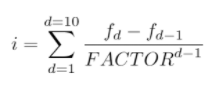
where *f_d* is the number of followers at depth *d* and *FACTOR* is some exponential smoothing constant (we set *FACTOR* = 2 for this paper).

In [ ]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = influence_df.drop("Depth 0", axis=1).corr()
sns.heatmap(corr, annot=True)
plt.title("Correlation Between Depths", fontsize=20)
plt.show()

Correlation matrix for each depth and total score. The total number of people each artist influences seems to level out around Depth 4 (correlations are very similar to every subsequent depth).

In [ ]:
def vis_figure(df, LOOK_AT):
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df['Influencer'][:LOOK_AT], y=df['Total'][:LOOK_AT]))
    fig.update_layout(title={'text': f"Top {LOOK_AT} Influencing Artists by Score", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Influence Score")
    fig.show()
    
vis_figure(influence_df, LOOK_AT)

In [ ]:
fig = go.Figure()
for i in range(LOOK_AT):
    fig.add_trace(go.Scatter(x=np.arange(0, MAX_DEPTH+1), y=influence_df.loc[:, influence_df.columns.str.contains("Depth")].iloc[i].to_numpy(), 
                             name=influence_df["Influencer"].iloc[i]))
    
fig.update_layout(xaxis=dict(range=[0, MAX_DEPTH]), title={'text': f"Artists Followers by Depth", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}}, xaxis_title="Depth", yaxis_title="Followers")
fig.show()

All of the artists on this list are big names (The Beatles, Elvis Presley!)

In [ ]:
print("Mean Influence Score: ", influence_df["Total"].mean())
fig = px.histogram(influence_df["Total"]) 
fig.update_layout(title={'text': "Distribution of Influence Scores", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}}, xaxis_title="Score", yaxis_title="Count", showlegend=False)
fig.show()

The distribution is clearly right-skewed and the mean influence score for all artists is ~209.

<h2> After how many years were most artists influenced? </h2>

In [ ]:
plt.figure(figsize=(16, 9))
diff = influence_data['follower_active_start'] - influence_data['influencer_active_start']
sns.histplot(diff, binwidth=10)
mean = diff.mean()
print(f"Mean Years After: {mean}")
plt.axvline(mean)
plt.xlabel("Years", fontsize=14)
plt.title("Influenced After X Years Distribution", fontsize=20)
plt.show()

In [ ]:
fm = influence_data.groupby('follower_name').mean()
fx = fm['follower_active_start'] - fm['influencer_active_start']

im = influence_data.groupby('influencer_name').mean()
ix = im['follower_active_start'] - im['influencer_active_start']

print(f"Influencer after average {round(ix.mean(), 3)} years\nFollower after average {round(fx.mean(), 3)} years")

pd.DataFrame(data=[ix, fx]).T.plot.hist(bins=np.arange(-20, 50, 1), stacked=True, figsize=(16, 9))
plt.legend(["Influencers After X Years", "Followers After X Years"])
plt.title("Influence After X Years Aggregated by Artist", fontsize=20)
plt.xlabel("Years", fontsize=14)
plt.show()

 On average, influencers influence their followers after 12.5 years, whereas followers are influenced by their influencers after 14.7 years. 


<h2> Visualizing and Exploring a Subnetwork </h2>

Although we can visualize a small portion of the network, it is hard to visualize the entire network in a meaningful way due to the sheer number of connections present. We present three visualizations below: one of a small subnetwork to Depth 10, one of a medium-sized subnetwork to Depth 10, and the final of the Beatles with Depth 1. We use ```influence_df``` to find which subnetworks to analyze.

In [ ]:
num_influence = {influence_df.loc[i]["Influencer"]: influence_df.loc[i]["Depth 1"] for i in range(len(influence_df))}
def step_nx(i_dict, influencer, vis, d, q, MAX_DEPTH):
    """
    Parameters:
    i_dict - Input graph
    influencer - Current influencer
    d - Depth
    q - Queue
    vis - Visited array (whether the influencer has been accounted for in the recursion already)
    
    Notes:
    Sufficient bfs for our small dataset. Use dynamic programming for O(n^2) complexity.
    """
    
    vis.add(influencer)
    
    if d > MAX_DEPTH+1 or influencer not in i_dict:
        return vis, q
    
    for follower in i_dict[influencer]:
        if follower not in vis:
            q.append([follower, d, influencer])
            
    return vis, q

def nx_influence(influencer, color_def, MAX_DEPTH, sep=0.5, SORT_BY="Influencer"):
    color_map = []
    for rgb_color in color_def:
        c_now = rgb_color.replace('rgb', '').replace('(', '').replace(')', '').split(',')
        color_map.append('#%02x%02x%02x' % (int(c_now[0]), int(c_now[1]), int(c_now[2])))
    
    G = nx.Graph(day="Music")
    vis = set()
    q = [[influencer, 1, influencer]]
    G.add_node(influencer, nodesize=num_influence[influencer]*2, color='#90EE90')
    while q:
        next_i = q[0][0]
        next_d = q[0][1]
        curr_i = q[0][2]
        del q[0]

        if next_i not in vis:
            if curr_i not in G.nodes:
                G.add_node(curr_i, nodesize=num_influence[curr_i] if curr_i in num_influence else 5, color=color_map[next_d-1])
            
            if next_i not in G.nodes:
                G.add_node(next_i, nodesize=num_influence[next_i] if next_i in num_influence else 5, color=color_map[next_d-1])
                
            G.add_weighted_edges_from([(curr_i, next_i, 1)])
            vis, q = step_nx(i_dict, next_i, vis, next_d+1, q, MAX_DEPTH=MAX_DEPTH)
            
    plt.figure(figsize=(20, 20))

    sizes = [G.nodes[node]['nodesize']*150 for node in G]
    colors = [G.nodes[node]['color'] for node in G]
    pos = nx.spring_layout(G, k=sep, iterations=5, seed=SEED)
    nx.draw(G, with_labels=False, node_size=sizes, node_color=colors, pos=pos, width=1, edge_color="#FFDEA2", font_weight='regular')
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=num_influence[node]/max(num_influence.values())*30+8 if node in num_influence else 8, ha='center', va='center')

    plt.savefig(f'./network_{influencer}_{MAX_DEPTH}.jpg')

<h3> Small Network - Juan Gabriel </h3>

In [ ]:
influence_df.loc[(influence_df['Depth 1'] > 10) & (influence_df['Depth 10'] > 100)]

In [ ]:
%time nx_influence("Juan Gabriel", px.colors.sequential.RdBu, 10, sep=0.3)

<h3> Medium-Sized Network - Coldplay </h3>

In [ ]:
influence_df.loc[(influence_df['Depth 1'] > 20) & (influence_df['Depth 10'] > 300)]

In [ ]:
%time nx_influence("Coldplay", px.colors.sequential.RdBu, 10, sep=0.3)

<h3> The Beatles </h3>

In [ ]:
%%time

G = nx.Graph(day="Music")
NAME = "The Beatles"
num_influence = {influence_df.loc[i]["Influencer"]: influence_df.loc[i]["Depth 1"] for i in range(len(influence_df))}
for i in range(len(influence_data)):
    influencer = influence_data['influencer_name'][i]
    follower = influence_data['follower_name'][i]
    if influencer == NAME:
        G.add_node(influencer, nodesize=num_influence[influencer])
        G.add_node(follower, nodesize=num_influence[follower] if follower in num_influence else 5)
        G.add_weighted_edges_from([(influencer, follower, 1)])
    
plt.figure(figsize=(30, 30))

sizes = [G.nodes[node]['nodesize']*100 for node in G]
pos = nx.spring_layout(G, k=0.15, iterations=20, seed=SEED)
nx.draw(G, node_color='orange', with_labels=False, node_size=sizes, pos=pos, width=1, edge_color="#FFDEA2", font_weight='regular')
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=num_influence[node]/max(num_influence.values())*30+8 if node in num_influence else 8, ha='center', va='center')

plt.savefig(f'./network_{NAME}.jpg')

# Task #3: Impact of Influencers

* Do the ‘influencers’ actually affect the music created by the followers? 

**Observation:** The more similar influencers and their followers’ music are to each other, the greater the impact that influencer had on the follower.
To analyze this potential similarity, we employ a K-Nearest Neighbors (KNN) algorithm, which finds the K artists with music most similar to another artist. First, we converted our features into Z-scores for a stable, standard unit. Then, we used Euclidean distance for our measure of similarity.

<h2> Influencer --> Follower </h2>

For this scenario, we set our K-value to 20, which means we store each influencer’s 20 closest neighbors (excluding itself) in a set. We find the intersection between that KNN-generated set and each influencer’s followers and take the length of that intersection to extract the total amount of overlap.

In [ ]:
ii_dict = {}
K_INF = 20
for influencer in i_dict:
    n = len(i_dict[influencer])
    if n < K_INF:
        continue
    
    try:
        neighbors_list = set(prediction_df[["artist_name", influencer]].sort_values(influencer).drop_duplicates()[1:K_INF+1]['artist_name'])
        ii_dict[influencer] = len(i_dict[influencer].intersection(neighbors_list))/K_INF
    except:
        pass

In [ ]:
def plot_dist(xx_dict, K, title_list):
    plt.figure(figsize=(16, 9))
    arr_now = np.array(list(xx_dict.values()))
    sns.histplot(arr_now*K, binwidth=1)
    mean = arr_now.mean()*K
    print(f"Mean KNN Out of {K}: {round(mean, 3)} ({round(mean/K*100, 3)}%)")
    plt.xlabel("Number of Neighbors", fontsize=14)
    plt.title(f"Is a {title_list[0]}'s Music Similar to Their {title_list[1]}?", fontsize=20)
    plt.axvline(mean)
    plt.show()
    
plot_dist(ii_dict, K_INF, ["Influencer", "Followers"])

Bar graph of the intersection between an influencer’s followers and the influencer’s 20 most similar artists. The vertical line represents the mean.

We can see that for a majority of influencers, only a few of their followers are the people who have music most similar to them. On average, only 1.3/20 artists (6.5%) overlap between an influencer’s followers and an influencer’s most similar artists. 


<h2> Follower --> Influencer </h2>

We then use a similar approach to analyze if a follower’s music is similar to that of their influencers. Since each follower has generally less influencers than influencers have followers, we set our K-value to 10 here. The results of our analysis are shown below.

In [ ]:
f_dict = {k: set() for k in influence_data['follower_name'].unique()}
for i in range(len(influence_data)):
    influencer = influence_data['influencer_name'][i]
    follower = influence_data['follower_name'][i]
    f_dict[follower].add(influencer)

In [ ]:
ff_dict = {}
K_FOL = 10
for follower in f_dict:
    n = len(f_dict[follower])
    if n < K_FOL:
        continue
    
    try:
        neighbors_list = set(prediction_df[["artist_name", follower]].sort_values(follower).drop_duplicates()[1:K_FOL+1]['artist_name'])
        ff_dict[follower] = len(f_dict[follower].intersection(neighbors_list))/K_FOL
    except:
        pass
    
plot_dist(ff_dict, K_FOL, ["Follower", "Influencers"])

Bar graph of the intersection between a follower’s influencers and the followers’s 10 most similar artists. The vertical line represents the mean.
For a vast majority of followers, very few of a follower’s influencers fall within the follower’s most similar artists, similar to the analysis of influencer → follower. 

On average, only 0.253/10 artists (2.5%) overlap between a follower’s influencers and the follower’s most similar artists. 

From these two analyses, on average, influencers seem to influence their followers more than followers are influenced by their influencers. However, neither influencers nor followers have that similar music compared to their counterparts—the influencer-follower connection between an artist and another artist does not confidently result in similar music between the two.

We leave out an application of the clustering algorithm here since it is not necessary and is most likely computationally inefficient.

# Task #4: Feature Importance & Predictive Modeling

* Are some music characteristics more ‘contagious’ than others, or do they all have similar roles in influencing a particular artist’s music?

It is quite difficult to figure out which characteristics necessarily translate over through the network; however, what we can look at is the importance of each characteristics towards defining an artist/their genre. We analyzed which characteristics are most important for distinguishing between different genres. We did so using two methods: feature importance with a predictive model and feature importance using statistical analyses.

Code courtesy to @DJ1852.

<h2> Feature Importance with Statistics </h2>

In [ ]:
full_music_data['artist_names'] = full_music_data['artist_names'].apply(eval)

In [ ]:
EXPORT_MUSIC = False

if EXPORT_MUSIC:
    genre_list = []
    for i in range(len(full_music_data)):
        if i%10000 == 0:
            print(i)
        for artist_id in full_music_data.loc[i]['artist_names']:
            if artist_id in id_genre_dict:
                for genre in id_genre_dict[artist_id]:
                    x = full_music_data.loc[i].append(pd.Series(genre))
                    genre_list.append(x)

    music_df = pd.DataFrame(data=genre_list)
    music_df.columns = list(full_music_data.columns)+["Genre"]
    music_df.to_csv("music_genre.csv")
else:
    music_df = pd.read_csv("../input/icm-problem-d/music_genre.csv").drop("Unnamed: 0", axis=1)
    
music_df

In [ ]:
normalized_music = music_df.copy().drop(drop_list, axis=1)
column_labels = normalized_music.columns.tolist()[2:14]

for i in column_labels:
    column = normalized_music[i].to_numpy()
    normalized_column = (column - np.average(column)) / np.std(column)
    normalized_music[i] = normalized_column
    
normalized_music = normalized_music.sort_values("Genre")
normalized_music

In [ ]:
normalized_genre_data = {}
new_genre_list = normalized_music['Genre'].unique()

for i in new_genre_list:
    genre_df = normalized_music.loc[normalized_music['Genre'] == i]
    genre_col_data = {}
    
    for j in column_labels:
        genre_col_vals = genre_df[j].tolist()
        genre_col_data[j] = sum(genre_col_vals) / len(genre_col_vals)
    
    normalized_genre_data[i] = genre_col_data

For each genre, we plot the average value of each feature using the songs of that genre in the “full_music_data” data set. We normalized the data for each feature in the data set using z-scores to put all the features on the same scale. The results of the analysis are seen in the figure below. Note that since we use z-scores to normalize the data, values may be negative to indicate that a certain genre’s feature’s average is below the average of that feature for all the songs in the data set.

In [ ]:
fig, ax = plt.subplots(5, 4, figsize = (30, 30))

xcounter = 0
ycounter = 0

for i in normalized_genre_data.keys():
    genre_vals = normalized_genre_data[i]
    ax[xcounter][ycounter].bar(genre_vals.keys(), genre_vals.values())
    ax[xcounter][ycounter].set_title(i, fontsize=20)
    ax[xcounter][ycounter].set_ylabel('Z-Score')
    ax[xcounter][ycounter].grid(False)
    for tick in ax[xcounter][ycounter].get_xticklabels():
        tick.set_rotation(90)
    
    xcounter = (xcounter + 1) % 5
    ycounter = (ycounter + 1) % 4

fig.tight_layout()
fig.show()

From the data above, we can isolate the distinctive features of each genre. For example, Avant-Garde is characterized with higher-than-average acousticness and lower-than-average loudness and energy and Country is characterized with higher-than-average danceability and lower-than-average instrumentalism and duration. Next, we analyze how each feature varies across each genre. For each feature, we plot the average value of the feature for each genre. Again, we used data normalized using z-scores to do this. The results are shown below.


In [ ]:
feature_distinctiveness = {}

fig, ax = plt.subplots(4, 3, figsize = (30, 30))

xcounter = 0
ycounter = 0

for i in column_labels:
    genre_column_vals = {}
    
    for j in new_genre_list:
        genre_column_vals[j] = normalized_genre_data[j][i]
    
    ax[xcounter][ycounter].bar(genre_column_vals.keys(), genre_column_vals.values())
    ax[xcounter][ycounter].set_title(i, fontsize=20)
    ax[xcounter][ycounter].set_ylabel('Z-Score')
    ax[xcounter][ycounter].grid(False)
    for tick in ax[xcounter][ycounter].get_xticklabels():
        tick.set_rotation(90)

    xcounter = (xcounter + 1) % 4
    ycounter = (ycounter + 1) % 3
    
    feature_std_across_genres = np.std(list(genre_column_vals.values()))
    feature_distinctiveness[i] = feature_std_across_genres

fig.tight_layout()
fig.show()

From the data above, we also get a sense for which features are most distinctive for each genre. For example, from the graph for comedy/speechiness, we can see that Comedy/Spoken has a much, much higher speachiness, liveliness, and explicit values than that of any other genre. We also see, for example, that New Age has a higher instrumentalness value than other genres and that Classical has lower loudness and energy values than other genres.

In [ ]:
sorted_feature_distinctiveness = {k: v for k, v in sorted(feature_distinctiveness.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(16, 9))
plt.bar(sorted_feature_distinctiveness.keys(), sorted_feature_distinctiveness.values())
plt.xticks(rotation=90)
plt.ylabel('Standard Deviation', fontsize=14)
plt.title('Feature Distinctiveness', fontsize=20)
plt.show()

We then measure the total standard deviation for the values in that data, and repeat this procedure for every feature. The feature with the highest standard deviation should be the most distinctive feature, and thus is most useful/important when distinguishing between genres.

<h2> Feature Importance & Predictive Modeling with XGBoost </h2>

**Because we have to use GPUs for Prediction Models/Feature Importance, the code for those is on another notebook linked here: https://www.kaggle.com/ironicninja/problem-d-prediction-models**

In conclusion, instrumentalness (rank 1 & 2) is definitely the most distinctive feature, followed by speechiness (rank 6 & 1) and acousticness (rank 2 & 4). Using both analyses, explicit is not a very distinctive feature.

# Task #5: Changes Over Time - Characteristics + Revolutionary Influencers

To first get an idea of how the music industry changes over time, we used the “full_music_data” data set to plot the number of songs released per year. This plot can be seen below.

Analysis courtesy to @treywiedmann and @DJ1852.

In [ ]:
fig = px.line(music_df.groupby('year').size())
fig.update_layout(title={'text': f"Number of Songs Per Year", 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Count", showlegend=False)
fig.show()

The number of songs in production drastically increased in the 1950s and 1960s.

We can extract some useful data regarding the historical events that might have affected the music industry and the influence of music. 1939 marks the end of the Great Depression, which could explain this rapid growth of music production after 1940, as new economic growth could have fueled the music industry. The invention of the computer in 1943 could also explain this large growth in song production, as computers could be used to produce, advertise, and sell music more easily. The years with the highest number of songs were in the 1960s, which coincides with the invention of cassette tapes (Kendall, 2017). These would have provided more access to songs to more people, as well as facilitate the selling and production of music. The number of songs per year started to decline rapidly around 2008, which could be due to the Great Recession in ‘08.

Using the “influence_data” data set, we also created a plot of the number of followers present per year, which can be seen below.

In [ ]:
fig = px.line(influence_data.groupby('follower_active_start').size())
fig.add_vrect(x0=1957, x1=1957, name="The Beatles begin")
fig.add_vrect(x0=1961, x1=1961, name="Bob Dylan begins")
fig.add_vrect(x0=1991, x1=1991, name="Advent of internet")
fig.update_layout(title={'text': "Followers Over Time", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}}, xaxis_title="Year", yaxis_title="Follower Start Count", showlegend=False)

Line 1 - The Beatles’ first release; Line 2 - Bob Dylan’s first release; Line 3 - World Wide Web. We would like to note that the above graph overcounts the number of followers as it does not remove duplicates of followers (followers who say they are influenced by more than one influencer). The shape of the graph should be similar to if we only counted unique followers though.

The trend in the number of followers over time is roughly comparable to the number of songs produced every year. The number of artists who start skyrocketed in the generation after The Beatles, Bob Dylan, and some of the other artists with large influence scores, which confirms the notion that our influence scores are somewhat accurate. Interestingly, the release of the World Wide Web is correlated with a sudden drop in follower count, which may be due to the advent of more original, contemporary music. 

In [ ]:
fig = go.Figure()
group_df = music_df.groupby(['Genre', 'year']).size()

for genre in genre_list:
    fig.add_trace(go.Scatter(x=group_df[genre].index, y=group_df[genre], name=genre, line_color=COLOR_MAP[genre]))

fig.update_layout(title={'text': "Number of Songs Per Year By Genre", 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Count")
fig.show()

Jazz peaked in the 1950s, whereas Pop/Rock grew drastically in the 1960s.

The Pop/Rock genre was responsible for most of the growth in music from the 1960s and onwards. Other genres of music declined while Pop/Rock grew. The Beatles, which we identified as the most influential artist, formed in 1957, which marks the rise of the Pop/Rock genre. The popularity and influentialness of the Beatles could have contributed to the rapid growth of Pop/Rock in the 1960s. Another observation from the data is that Jazz music rose and declined rapidly in popularity from about 1950 to 1970, and was actually the most published genre around 1955. This roughly marks the period when Bebop and cool Jazz were popular. The decline of Jazz from 1955 onwards also mirrors the growth of Pop/Rock. 

In [ ]:
fig = px.bar(music_df.groupby('year').size().diff())
fig.update_layout(title={'text': f"Increase in Songs Over Time", 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Increase", showlegend=False)
fig.show()

In [ ]:
song_features = normalized_music.columns[2:14]
song_features

In [ ]:
normalized_music_by_year = normalized_music.groupby('year').mean()
fig = px.line(normalized_music_by_year[song_features])
fig.update_layout(title={'text': "Features for Songs Over Time", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Z Score")
fig.show()

Features of songs over time. Given the graphs of these features over time, we looked at important changes that indicated musical revolutions.

The most apparent change of music was in the 1960s, where the acousticness of music dropped heavily. This identified one of the most important revolutions in music history, when electric guitars and amplification became a mainstay in popular music. Following this, acousticness continued to decline with the introduction of synthesizers and sampling.

Explicitness also rose over time, most notably in the past decade, and this actually indicated a revolution in how music reaches its listeners. In the age of radio, stations censored lyrics and generally discouraged explicitness. However, with the explosion of streaming services in the past few years, musicians that publish to these services are freer to use explicit language in their songs (Ross, 2017).

Loudness also followed a steady upwards trend, which indicated a musical phenomenon referred to as the “loudness war”. Throughout time, producers continued to drive up the loudness of their songs, as louder songs generally stood out more compared to quieter ones (NPR). In the 1990s, the arrival of digital signal processing allowed producers to drive up loudness even more, which correlated with increasing loudness on the graph.

Finally, we noticed that valence followed a downwards trend. Similarly we calculated the average mode each year, and that also followed a downwards trend. Since a mode of 0 indicated a minor key, and minor keys are generally less bright than major keys, we took this as another indicator of decreasing positivity. Though this pattern was interesting, it was difficult to connect it to any specific events, perhaps it indicated that people are generally more negative recently, or that sad music has become more trendy.


<h3> Extra TSNE Reduced Graph Over Time </h3>

In [ ]:
music_by_year = music_df.groupby('year').mean()
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, random_state=SEED))])
X = music_by_year.to_numpy()
genre_embedding = tsne_pipeline.fit_transform(X)
projection_year = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection_year['year'] = music_by_year.index
projection_year

In [ ]:
fig = px.scatter(projection_year, x='x', y='y', color='year', hover_data=['x', 'y', 'year'])
fig.update_layout(title={'text': "Yearly Progressing in Music After Dimensionality Reduction", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}})
fig.show()

Potential code for adding genre labels.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(name="years", x=projection_year['x'], y=projection_year['y'], text=projection_year['year'], marker_color=projection_year['year'], 
                               marker=dict(colorbar=dict(title="year")), mode='markers'))
fig.add_trace(go.Scatter(name='genres', x=mean_projection['x'], y=mean_projection['y'], text=mean_projection['genre'], mode='markers'))
fig.update_layout(title={'text': "Yearly Progressing in Music After Dimensionality Reduction", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}})
fig.show()

<h3> Specific Genre Analysis - R&B; </h3>

In [ ]:
normalized_music_genre = normalized_music.groupby(['Genre', 'year']).mean()
fig = px.line(normalized_music_genre.loc['R&B;'][song_features])
fig.update_layout(title={'text': "Features for R&B; Over Time", 'x': 0.5,
                             'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Z Score")
fig.show()

In [ ]:
genres = []
for i in range(len(influence_df)):
    my_set = id_genre_dict[influence_df.loc[i]['Influencer']]
    for genre in my_set:
        genres.append(genre)
        break

In [ ]:
influence_genre_df = influence_df.copy()
influence_genre_df['genre'] = genres
vis_figure(influence_genre_df.loc[influence_genre_df['genre'] == 'R&B;'], LOOK_AT)

Finally, we noticed that valence followed a downwards trend. Similarly we calculated the average mode each year, and that also followed a downwards trend. Since a mode of 0 indicated a minor key, and minor keys are generally less bright than major keys, we took this as another indicator of decreasing positivity. Though this pattern was interesting, it was difficult to connect it to any specific events, perhaps it indicated that people are generally more negative recently, or that sad music has become more trendy.

(Additionally, we noticed that popularity followed an upwards trend, but since the popularity metric was based on recent listeners, it seemed obvious that the more recent songs would be more popular.)

Finally, we analyzed genre and artist-specific trends (Fig, 25-26). We focused on R&B, and found a strong downwards trend in the average acousticness. Then, we filtered songs in R&B to only ones authored by James Brown, the most influential in the genre according to our metrics, and we found the same downwards trend. It was hard to establish whether he caused this trend though, especially considering the small amount of data we had for the artist. (The graphs are not necessarily depicted here).

# Conclusion

From our K-Means clustering analyses, we find that artists are much more similar within genres than between genres. From our Pearson’s Correlation matrix, we also find that certain genres are more closely related feature wise to each other than to other genres (Fig 5). Using a data network, we were able to model the influence of artists, and we found that the most influential artists were The Beatles.

Using a KNN algorithm, we were able to measure the similarity between influencers and their followers. We found that influencers seem to influence their followers more than followers are influenced by their influencers. However, in all there are not that many significant similarities between the music of influencers and their followers. We also determined the features that distinguish genres from each other. By using the standard deviation of the features across genres, we found that instrumentalness was the best feature to distinguish between genres.

By analyzing the changes in song number, genre popularity, and song features over time, we were able to attribute some of these changes to certain historical events. For example, the rise of new technologies like the cassette tape and CD in the second half of the 20th century sparked rapid growth in music production, and the formation of the Beatles marked the rise of the pop/rock genre.

Additionally, we found that the popularization of the electric guitar led to a drop in the acousticness of songs, and the popularization of music streaming platforms led to higher explicitness in songs. Finally, we connected trends in genres to major influencers in those genres, for example, we observed that a decrease in the overall acousticness of R&B coincided with a decrease in the acousticness of James Brown’s songs.



# References

Links for the references are at the bottom of the official paper.

* Dabbura, I. (2018).  K-means Clustering: Algorithm, Applications, Evaluation Methods, and Drawbacks.
* Huang, B. (2014). What Kind of Impact Does Our Music Really Make on Society? 
* Kapri, A. (2020). PCA vs LDA vs T-SNE — Let’s Understand the difference between them!
* Kendall, J. (2017). From Discs to Digital: The Odd History of Music Formats.
* NPR (2009). The Loudness Wars: Why Music Sounds Worse.
* Ross, E. (2017). Parental Advisory: How Songs With Explicit Lyrics Came to Dominate the Charts.